# Discover Floods at the Shebella River in Beledweyne for November 2023

Intense rainfall in November 2023 triggered widespread flooding in Somalia, Ethiopia, and Kenya, following a prolonged drought from 2020 to 2023. The floods resulted in over 100 fatalities and displaced 700,000 people, reported by the United Nations Office for the Coordination of Humanitarian Affairs since October 1. Excessive rainfall in the highlands of Ethiopia and Somalia elevated the Shebelle River, causing it to overflow on November 11. Subsequent rain inundated central Somalia, including Beledweyne, displacing around 250,000 residents (90% of the population). Beledweyne was selected as the focal point and is visulized in the image below from November 15, 2023. A comparative image from late October before the flood highlights the extensive flooding later in November. The Sentinel-2 images visualize the area in true and false color, emphasizing water presence in shades of blue.

https://earthobservatory.nasa.gov/images/152108/devastating-flooding-in-east-africa

In [1]:
!pip3 install cartopy

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import xarray as xr
import numpy as np
from datetime import datetime

import os
from glob import glob

import rasterio as rio
import cv2

from skimage import exposure
import shutil

from eodag import EODataAccessGateway, setup_logging

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import matplotlib.colors

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

Set up working directory

In [3]:
workspace = "/home/eoafrica/Products/downloads/aethiopien"
if not os.path.isdir(workspace):
    os.mkdir(workspace)

Configured eodag to download products in this workspace directory.

In [4]:
workspace

'/home/eoafrica/Products/downloads/aethiopien'

In [5]:
os.environ["EODAG__PEPS__DOWNLOAD__OUTPUTS_PREFIX"] = os.path.abspath(workspace)

In [6]:
start_dt="2023-10-05"
end_dt ="2023-12-05"

In [7]:
setup_logging(0)  # 0: nothing, 1: only progress bars, 2: INFO, 3: DEBUG

dag = EODataAccessGateway()
geometry = "POLYGON ((42.991562 6.035224, 42.991562 6.076534, 43.054047 6.076534, 43.054047 6.035224, 42.991562 6.035224))"
search_results, total_count = dag.search(
    productType="S2_MSI_L2A",
    geom=geometry,
    start=start_dt,
    end=end_dt,
)

Downloading all products

In [8]:
search_results

SearchResult([EOProduct(id=S2A_MSIL2A_20231128T072231_N0509_R006_T38NKM_20231128T105351, provider=creodias_s3),
              EOProduct(id=S2A_MSIL2A_20231118T072201_N0509_R006_T38NKM_20231118T105454, provider=creodias_s3),
              EOProduct(id=S2B_MSIL2A_20231014T071839_N0509_R006_T38NKM_20231014T100243, provider=creodias_s3),
              EOProduct(id=S2A_MSIL2A_20231009T071811_N0509_R006_T38NKM_20231009T105159, provider=creodias_s3),
              EOProduct(id=S2B_MSIL2A_20231203T072249_N0509_R006_T38NKM_20231203T095040, provider=creodias_s3),
              EOProduct(id=S2B_MSIL2A_20231123T072219_N0509_R006_T38NKM_20231123T094933, provider=creodias_s3),
              EOProduct(id=S2B_MSIL2A_20231024T071949_N0509_R006_T38NKM_20231024T095926, provider=creodias_s3),
              EOProduct(id=S2A_MSIL2A_20231019T071911_N0509_R006_T38NKM_20231019T105657, provider=creodias_s3),
              EOProduct(id=S2B_MSIL2A_20231103T072049_N0509_R006_T38NKM_20231103T095136, provider=creodi

In [9]:
setup_logging(0)
dag.download_all(search_results)

['/tmp/S2A_MSIL2A_20231128T072231_N0509_R006_T38NKM_20231128T105351',
 '/tmp/S2B_MSIL2A_20231014T071839_N0509_R006_T38NKM_20231014T100243',
 '/tmp/S2B_MSIL2A_20231203T072249_N0509_R006_T38NKM_20231203T095040',
 '/tmp/S2B_MSIL2A_20231024T071949_N0509_R006_T38NKM_20231024T095926',
 '/tmp/S2B_MSIL2A_20231103T072049_N0509_R006_T38NKM_20231103T095136',
 '/tmp/S2A_MSIL2A_20231029T072021_N0509_R006_T38NKM_20231029T105205',
 '/tmp/S2A_MSIL2A_20231118T072201_N0509_R006_T38NKM_20231118T105454',
 '/tmp/S2B_MSIL2A_20231123T072219_N0509_R006_T38NKM_20231123T094933',
 '/tmp/S2B_MSIL2A_20231113T072139_N0509_R006_T38NKM_20231113T095110',
 '/tmp/S2A_MSIL2A_20231009T071811_N0509_R006_T38NKM_20231009T105159',
 '/tmp/S2A_MSIL2A_20231019T071911_N0509_R006_T38NKM_20231019T105657']

Shift the data to workspace = "/home/eoafrica/Products/downloads/aethiopien"

In [10]:

for result in search_results:
    product_name = result.properties['title']
    s2_dir = "/tmp/" + product_name

    tci_files = glob(s2_dir + "/GRANULE/*/IMG_DATA/R10m/*.jp2")

    # Moving files to the destination directory
    for file_path in tci_files:
        if not os.path.exists(os.path.join(workspace, os.path.basename(file_path))):
            shutil.move(file_path, workspace)

# also in case: Remove the empty source directory
# shutil.rmtree("/tmp/" + product_name)


We quickly sort the results by date to plot the images before the fire first and the images after the fire last.

While doing so, we already use the library rasterio to read the image into a numpy array.

Since matplotlib expects the z-axis that represents the image bands (red, green and blue) to be the first dimension, we need to re-arrange the dimensions before plotting the images by using numpy.transpose.

Zoom and trasnpose the image:

In [11]:
search_results_kv = {}
for result in search_results:
    # getting the date of aquisition
    publication_date_str = result.properties.get("publicationDate", "")
    publication_date = datetime.strptime(publication_date_str, '%Y-%m-%dT%H:%M:%S.%fZ')
    if glob(os.path.join(workspace, f"*_{publication_date.strftime('%Y%m%d')}*TCI_10m.jp2")): 
        print(publication_date.strftime('%Y%m%d'))
        tci = glob(os.path.join(workspace, f"*_{publication_date.strftime('%Y%m%d')}*TCI_10m.jp2"))[0]
        with rio.open(tci) as src:
            tci_array = src.read()
            roi = tci_array[:, 500:1000, 4000:5500]
        transposed_tci = np.transpose(roi, (1, 2, 0))
        search_results_kv[result.properties["publicationDate"]] = transposed_tci

20231128
20231118
20231014
20231009
20231203
20231123
20231024
20231019
20231103
20231113
20231029


Plot the image

In [12]:
threshold = 0.85  # Minimum percentage of non-cloudy pixels
for date, array in sorted(search_results_kv.items()):
    # Calculate the percentage of non-cloudy pixels
    non_cloudy_percentage = np.sum(roi != 255) / array.size

    # Check if the non-cloudy percentage meets the threshold
    if non_cloudy_percentage >= threshold:
        plt.imshow(roi)
        plt.title(f'Image Date: {date}, Non-Cloudy Percentage: {non_cloudy_percentage:.2%}')
        plt.show()
    else:
        print(f"Skipping {date} due to insufficient non-cloudy pixels.")

Skipping 2023-10-09T12:20:39.980Z due to insufficient non-cloudy pixels.
Skipping 2023-10-14T13:23:29.966Z due to insufficient non-cloudy pixels.
Skipping 2023-10-19T11:59:30.663Z due to insufficient non-cloudy pixels.
Skipping 2023-10-24T11:24:29.103Z due to insufficient non-cloudy pixels.
Skipping 2023-10-29T11:54:10.240Z due to insufficient non-cloudy pixels.
Skipping 2023-11-03T11:31:57.916Z due to insufficient non-cloudy pixels.
Skipping 2023-11-13T11:15:17.070Z due to insufficient non-cloudy pixels.
Skipping 2023-11-18T12:07:02.982Z due to insufficient non-cloudy pixels.
Skipping 2023-11-23T11:08:01.235Z due to insufficient non-cloudy pixels.
Skipping 2023-11-28T17:32:09.322Z due to insufficient non-cloudy pixels.
Skipping 2023-12-03T11:41:54.401Z due to insufficient non-cloudy pixels.


Extract the two cloud free images

In [13]:
search_results_kv.keys()

dict_keys(['2023-11-28T17:32:09.322Z', '2023-11-18T12:07:02.982Z', '2023-10-14T13:23:29.966Z', '2023-10-09T12:20:39.980Z', '2023-12-03T11:41:54.401Z', '2023-11-23T11:08:01.235Z', '2023-10-24T11:24:29.103Z', '2023-10-19T11:59:30.663Z', '2023-11-03T11:31:57.916Z', '2023-11-13T11:15:17.070Z', '2023-10-29T11:54:10.240Z'])

Looking thru the data, two images withou many clouds before and after the flood event have been choosen

In [14]:
image1 = search_results_kv['2023-10-09T12:20:39.980Z']
image2 = search_results_kv['2023-11-23T11:08:01.235Z']


Calculate the flooded extent while comparing the two cloud free images

Calculate the absolute difference between the two images

In [15]:
# Create a binary mask for values equal to 255
scl_masked = (image1 != 255) | (image2 != 255)

masked_image1 = np.where(scl_masked, image1, 0)
masked_image2 = np.where(scl_masked, image2, 0)


Text(0.5, 1.0, 'Cloud masked image2')

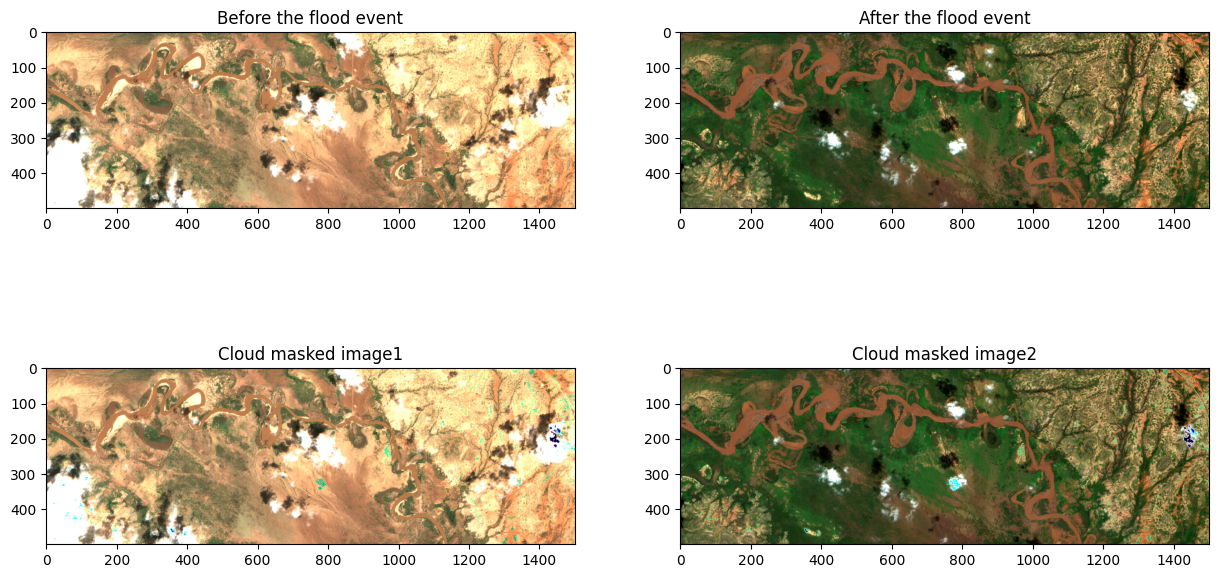

In [16]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
plt.imshow(image1)
plt.title('Before the flood event')

plt.subplot(2, 2, 2)
plt.imshow(image2)
plt.title('After the flood event')

plt.subplot(2, 2, 3)
plt.imshow(masked_image1)
plt.title('Cloud masked image1')

plt.subplot(2, 2, 4)
plt.imshow(masked_image2)
plt.title('Cloud masked image2')


Calculate the absolute difference between the masked images


In [17]:
difference = cv2.absdiff(masked_image1, masked_image2)

In [18]:
gray_difference = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)
_, thresholded = cv2.threshold(gray_difference, 55, 255, cv2.THRESH_BINARY)


blue represents negative differences, white represents no difference, and red represents positive differences. 

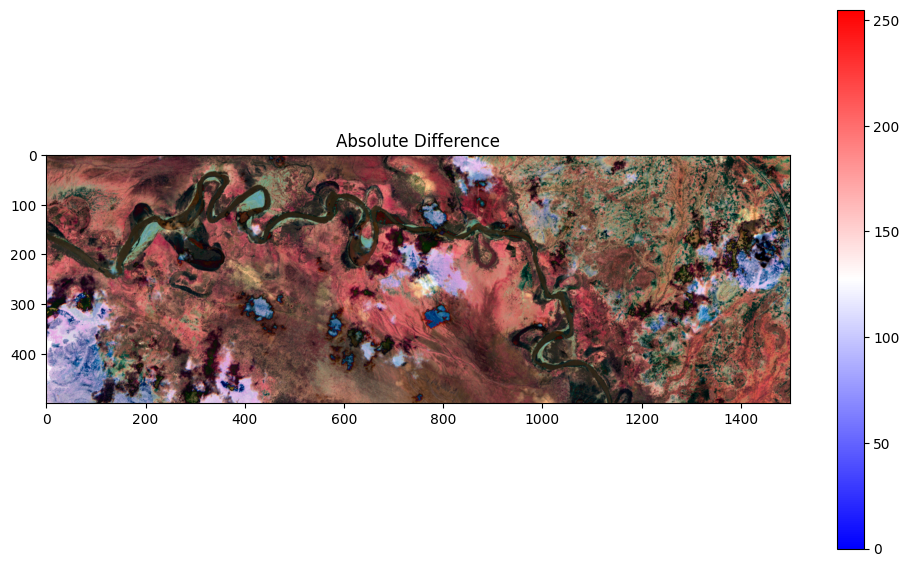

In [19]:
plt.figure(figsize=(12, 7))
plt.imshow(difference, cmap='bwr', vmin=np.min(difference), vmax=np.max(difference))  # Adjust vmin and vmax based on your data
plt.title('Absolute Difference')
plt.colorbar()

Find contours in the thresholded image and mask them out to archive the pure flood extent

In [20]:
contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask = np.zeros_like(gray_difference)

# Getting the contours on the mask
cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)
# flooded extent
flooded_extent = np.sum(mask > 0)

In [21]:
flooded_extent

638651

Visualize the difference image and flooded extent

Text(0.5, 1.0, 'Flooded Extent')

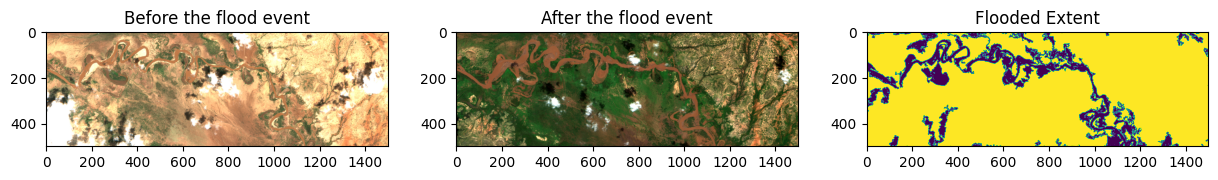

In [22]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.imshow(image1)
plt.title('Before the flood event')

plt.subplot(1, 3, 2)
plt.imshow(image2)
plt.title('After the flood event')

plt.subplot(1, 3, 3)
plt.imshow(mask, cmap='viridis')
plt.title('Flooded Extent')



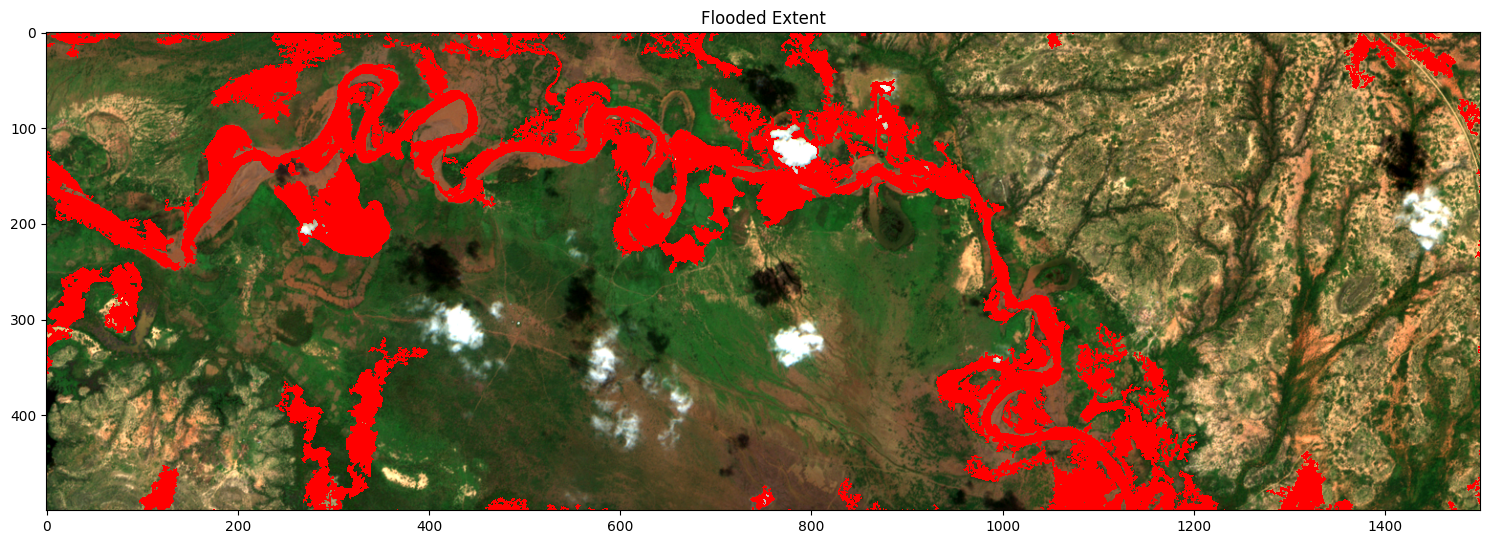

In [23]:
from matplotlib.colors import ListedColormap
masked_binary = np.where(0, np.nan, mask)

plt.figure(figsize=(15, 15))
plt.imshow(image2, alpha=1.0) 
colors = ['red', 'blue']

cmap = ListedColormap(colors, name='custom_colormap', N=len(colors))
cmap.colors[1] = (0, 0, 0, 0)  # alpha (transparency) of the second class to 0

# Plot the binary layer with the custom colormap
plt.imshow(masked_binary, cmap=cmap)

plt.title('Flooded Extent')

plt.tight_layout()  
plt.show()

## Using Sentinel 1

SAR's inherent capability to observe during cloud cover and Sentinel-1's frequent revisits makes it ideal for flood monitoring. It can be used to assess the extent of flooded areas and the impact on human, economic and environmental loss. Furthermore, high-resolution digital elevation models (DEMs) generated through Sentinel-1's interferometric modes can be used to conduct run-off and inundation analysis in areas previously lacking elevation data.

Calm open water surfaces appear flat when being hit by C-band SAR radiation, and the radiation is scattered away from the satellite’s sensor. Consequently, the received energy (measured as backscatter) is low and shows high contrast to general land surfaces. Generally, the underlying principle of the SAR-based flood mapping methods is to identify low backscatter measurements where land is expected under normal conditions. Two SAR polarisations (VV and VH) are required to allow a detection of flooded vegetation.

In [10]:
setup_logging(0)  # 0: nothing, 1: only progress bars, 2: INFO, 3: DEBUG

dag = EODataAccessGateway()
geometry = "POLYGON ((42.991562 6.035224, 42.991562 6.076534, 43.054047 6.076534, 43.054047 6.035224, 42.991562 6.035224))"
search_results_s1, total_count = dag.search(
    productType="S1_SAR_GRD",
    geom=geometry,
    start=start_dt,
    end=end_dt,
)

In [11]:
search_results_s1

SearchResult([EOProduct(id=S1A_IW_GRDH_1SDV_20231014T025406_20231014T025431_050755_061DC7_54C6, provider=creodias_s3),
              EOProduct(id=S1A_IW_GRDH_1SDV_20231201T025405_20231201T025430_051455_0635C6_1E14, provider=creodias_s3),
              EOProduct(id=S1A_IW_GRDH_1SDV_20231107T025406_20231107T025431_051105_0629BD_2462, provider=creodias_s3),
              EOProduct(id=S1A_IW_GRDH_1SDV_20231119T025406_20231119T025431_051280_062FCC_4E9D, provider=creodias_s3)])

In [12]:
setup_logging(0) 
dag.download_all(search_results_s1)

['/tmp/S1A_IW_GRDH_1SDV_20231014T025406_20231014T025431_050755_061DC7_54C6',
 '/tmp/S1A_IW_GRDH_1SDV_20231107T025406_20231107T025431_051105_0629BD_2462',
 '/tmp/S1A_IW_GRDH_1SDV_20231201T025405_20231201T025430_051455_0635C6_1E14',
 '/tmp/S1A_IW_GRDH_1SDV_20231119T025406_20231119T025431_051280_062FCC_4E9D']

Load, zoom and transpose, and quick look at the S1 VV data

In [17]:
sorted_search_results_s1 = sorted(search_results_s1, key=lambda x: datetime.strptime(x.properties.get("publicationDate", ""), '%Y-%m-%dT%H:%M:%S.%fZ'))
sorted_search_results_s1

[EOProduct(id=S1A_IW_GRDH_1SDV_20231014T025406_20231014T025431_050755_061DC7_54C6, provider=creodias_s3),
 EOProduct(id=S1A_IW_GRDH_1SDV_20231107T025406_20231107T025431_051105_0629BD_2462, provider=creodias_s3),
 EOProduct(id=S1A_IW_GRDH_1SDV_20231119T025406_20231119T025431_051280_062FCC_4E9D, provider=creodias_s3),
 EOProduct(id=S1A_IW_GRDH_1SDV_20231201T025405_20231201T025430_051455_0635C6_1E14, provider=creodias_s3)]

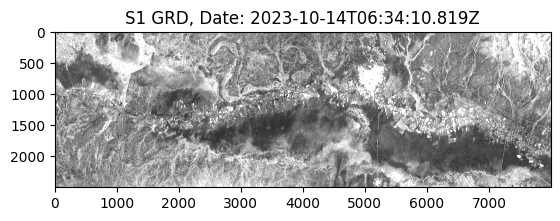

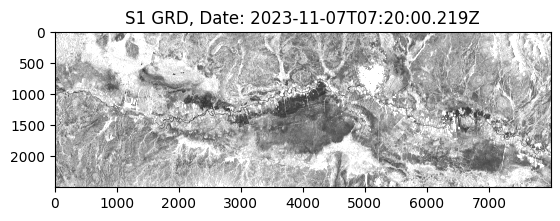

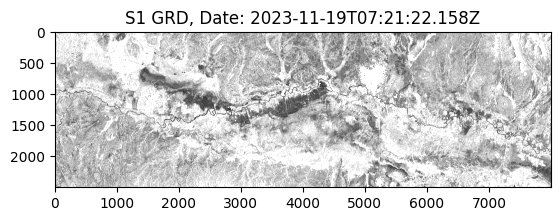

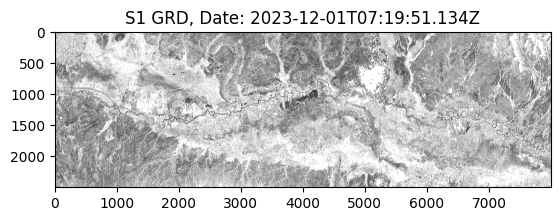

In [24]:
search_results_kv_s1 = {}
for result in sorted_search_results_s1:
    # getting the date of aquisition
    publication_date_str = result.properties.get("publicationDate", "")
    publication_date = datetime.strptime(publication_date_str, '%Y-%m-%dT%H:%M:%S.%fZ')
    if glob(os.path.join('/tmp', f"S1A_IW_GRDH_1SDV_*{publication_date.strftime('%Y%m%d')}*")):
        s1 = glob(os.path.join('/tmp', f"S1A_IW_GRDH_1SDV_*{publication_date.strftime('%Y%m%d')}*", 'measurement', '*vv*'))[0]
        with rio.open(s1) as src:
            s1_array = src.read()
            s1_array = np.flip(s1_array, axis=2)
            roi = s1_array[:, 6000:8500, 12000:20000]
        transposed_s1 = np.transpose(roi, (1, 2, 0))
        plt.imshow(transposed_s1, cmap='gray', vmin=0, vmax=255)
        plt.title(f'S1 GRD VV, Date: {publication_date_str}')
        plt.show()
        search_results_kv_s1[result.properties["publicationDate"]] = transposed_s1

 Analysing the flood event with S1

In [25]:
search_results_kv_s1.keys()

dict_keys(['2023-10-14T06:34:10.819Z', '2023-11-07T07:20:00.219Z', '2023-11-19T07:21:22.158Z', '2023-12-01T07:19:51.134Z'])

Choosing an image before and after the flood event

In [26]:
image1 = search_results_kv_s1['2023-10-14T06:34:10.819Z']
image2 = search_results_kv_s1['2023-12-01T07:19:51.134Z']

In [47]:
def plot_sentinel1_difference(before, after, threshold=0):
    """
    Plot the difference between two Sentinel-1 images.
    """
    # Checking that both arrays have the same shape
    min_rows = min(before.shape[0], after.shape[0])
    min_cols = min(before.shape[1], after.shape[1])

    before = before[:min_rows, :min_cols, :]
    after = after[:min_rows, :min_cols, :]
    difference = before - after

    # Apply thresholding to highlight changes
    #difference[difference <= threshold] = 0

    plt.figure(figsize=(20, 15))

    plt.subplot(1, 3, 1)
    plt.imshow(before, cmap='gray', vmin=0, vmax=255)
    plt.title('Before Flood')

    plt.subplot(1, 3, 2)
    plt.imshow(after, cmap='gray', vmin=0, vmax=255)
    plt.title('After Flood')

    plt.subplot(1, 3, 3)
    plt.imshow(difference, cmap='coolwarm')
    plt.title('Difference (After - Before)')
    plt.colorbar(shrink=0.1)

    plt.tight_layout()
    plt.show()

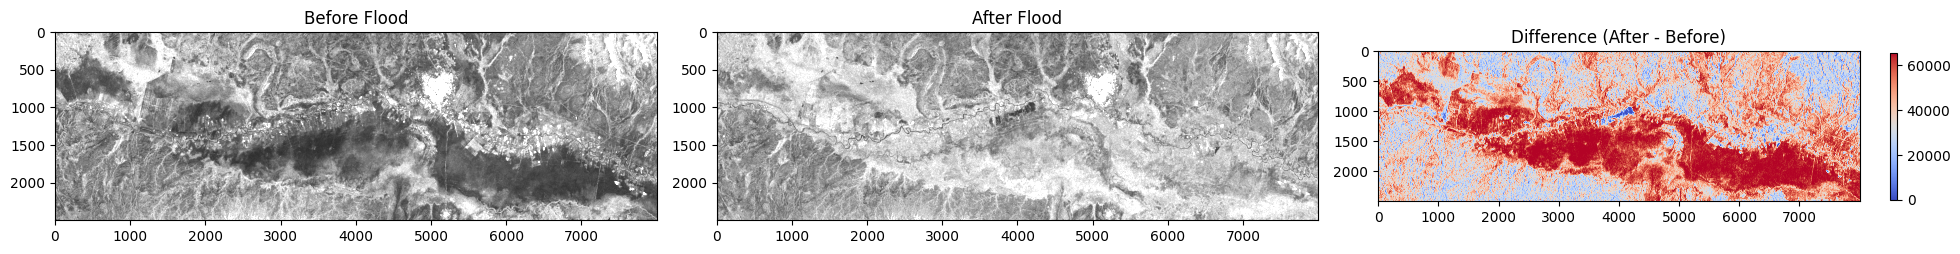

In [48]:
plot_sentinel1_difference(image1, image2, threshold = 0)

Blue regions indicate where the values in the "After Flood" image are lower than the corresponding values in the "Before Flood" image. Therefore, negative values are represented with blue/cool colors.

Red regions indicate where the values in the "After Flood" image are higher than the corresponding values in the "Before Flood" image. Therefore, positives values are represented with red/warm colors

Neutral colors (closer to white) represent areas where there is little to no difference between the two images.